In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RDKit installation

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [3]:
condacolab.check()

✨🍰✨ Everything looks OK!


In [5]:
!conda install -c conda-forge rdkit

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

# RDKit load

In [6]:
import rdkit
import rdkit.Chem

# Extract specific SMILES and data (absorption max)

The data file used in this notebook is available in this article [https://doi.org/10.1038/s41597-020-00634-8](https://doi.org/10.1038/s41597-020-00634-8).

In [7]:
from tqdm import tqdm

smiles = []
abs_max_list = []

for l in tqdm(open("DB for chromophore_Sci_Data_rev02.csv").readlines()[1:]):
  dat = l.strip().split(',')
  if dat[2]=='ClCCl' and dat[3]!='NaN':     # select the cases where solvent is dichloromethane
    smiles.append(dat[1])
    abs_max_list.append(float(dat[3]))

print()
print(f"Number of SMILES strings: {len(smiles)}")
print(f"Number of Abs_Max: {len(abs_max_list)}")

100%|██████████| 20236/20236 [00:00<00:00, 664463.70it/s]


Number of SMILES strings: 2429
Number of Abs_Max: 2429


# Transform SMILES to MACCS Key representation for organic compounds

Reference: https://chem.libretexts.org/Courses/Intercollegiate_Courses/Cheminformatics/06%3A_Molecular_Similarity/6.01%3A_Molecular_Descriptors  

The MACCS (Molecular ACCess System) keys [17,18] are one of the most commonly used structural keys. They are sometimes referred to as the MDL keys, named after the company that developed them [the MDL Information Systems (now BIOVIA)]. While there are two sets of MACCS keys (one with 960 keys and the other containing a subset of 166 keys), only the shorter fragment definitions are available to the public. These 166 public keys are implemented in popular open-source cheminformatics software packages, including RDKit [20], OpenBabel [21,22], CDK [23,24], etc. The fragment definitions for the MACCS 166 keys can be found in this document:

https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

In [8]:
from rdkit.Chem import MACCSkeys

# SMILES -> Mol-type example
mol = rdkit.Chem.MolFromSmiles(smiles[0])

# Mol-type -> MACCS key
vec = MACCSkeys.GenMACCSKeys(mol)

In [9]:
# BitVect object -> list
vec_list = vec.ToList()
print(len(vec_list)), print(vec_list)

167
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


(None, None)

In [10]:
# generate MACCS keys from SMILES for all species
X_raw = []
for smi in tqdm(smiles):
  vec = MACCSkeys.GenMACCSKeys(rdkit.Chem.MolFromSmiles(smi))
  X_raw.append(vec.ToList())

100%|██████████| 2429/2429 [00:10<00:00, 221.39it/s]


# Maximum absorption wave length

In [12]:
import numpy as np

y = np.array(abs_max_list)
min_y = min(y)
max_y = max(y)

# normalization
y = (y - min(y)) / (max(y) - min(y))

print(f"Max absorption wavelength: {max_y:.4f} (nm)")
print(f"Min absorption wavelength: {min_y:.4f} (nm)")
print(f"Max - Min wavelength: {max_y - min_y:.4f} (nm)")

Max absorption wavelength: 826.0000 (nm)
Min absorption wavelength: 230.0000 (nm)
Max - Min wavelength: 596.0000 (nm)


# Split train/test sets

In [13]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)   # 80/20 train/test split

In [14]:
print(len(X_train))
print(len(X_test))

1943
486


In this version 2 notebook, the training set is again split into a training/validation set.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)   #90/10 train/validation split

In [16]:
import torch
torch.manual_seed(1234)

# numpy array -> tensor
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [17]:
print(X_train.shape), print(y_train.shape)

torch.Size([1748, 167])
torch.Size([1748])


(None, None)

In [18]:
from torch.utils.data import TensorDataset, DataLoader

# TensorDataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader
loader_train = DataLoader(ds_train, batch_size=128, shuffle=True, drop_last=True)
loader_test = DataLoader(ds_test, batch_size=128, shuffle=False)

In [19]:
from torch import nn

# model
model = nn.Sequential(
    nn.Linear(167, 50),       # input_dim = 167
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 50),
    nn.Tanh(),
    nn.Linear(50, 20),
    nn.Tanh(),
    nn.Linear(20, 1)          # final output_dim = 1
)
print(model)

Sequential(
  (0): Linear(in_features=167, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=1, bias=True)
)


In [20]:
from torch import optim

# loss function
loss_fn = nn.MSELoss()     # mean squared error as it's a regression problem

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

Unlike the version 1 file, we now calculate the validation loss from the train function.

In [22]:
def train(epoch, x_val, y_val):
  loss_list = []
  model.train()

  for data, targets in loader_train:
    optimizer.zero_grad()
    outputs = model(data)
    outputs = outputs[:,0]            # to make the shape of targets the same as outputs

    loss = loss_fn(outputs, targets)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

  val_loss = loss_fn(model(X_val)[:,0], y_val)
  print(f"epoch {epoch} // Loss: {loss:.5f} // Val_loss: {val_loss:.5f}")

  # return loss values at each epoch
  return loss.item(), val_loss.item()

In [23]:
def test():
  model.eval()
  mse = 0

  with torch.no_grad():
    for data, targets in loader_test:
      outputs = model(data)
      outputs = outputs[:,0]
      mse += torch.sum((outputs - targets)**2)

  mse /= len(loader_test.dataset)

  print(f'\n prediction accuracy with the test data: {mse:.3f} // {mse*max(y):.3f}')

In [24]:
test() # test accuracy without training the model


 prediction accuracy with the test data: 0.236 // 0.236


As we normalized the wavelength, the mean squared error of 0.236 is equal to 0.236 x 596 = ~140 nm<sup>2</sup>.  
This is the mse without any training.

In [27]:
for epoch in range(100):
  train(epoch, X_val, y_val)

test()

epoch 0 // Loss: 0.09149 // Val_loss: 0.07059
epoch 1 // Loss: 0.02910 // Val_loss: 0.03419
epoch 2 // Loss: 0.02925 // Val_loss: 0.02693
epoch 3 // Loss: 0.03151 // Val_loss: 0.02607
epoch 4 // Loss: 0.02968 // Val_loss: 0.02606
epoch 5 // Loss: 0.03270 // Val_loss: 0.02601
epoch 6 // Loss: 0.03458 // Val_loss: 0.02588
epoch 7 // Loss: 0.02878 // Val_loss: 0.02572
epoch 8 // Loss: 0.02968 // Val_loss: 0.02542
epoch 9 // Loss: 0.02923 // Val_loss: 0.02517
epoch 10 // Loss: 0.02801 // Val_loss: 0.02499
epoch 11 // Loss: 0.02487 // Val_loss: 0.02472
epoch 12 // Loss: 0.02863 // Val_loss: 0.02452
epoch 13 // Loss: 0.02380 // Val_loss: 0.02427
epoch 14 // Loss: 0.02859 // Val_loss: 0.02408
epoch 15 // Loss: 0.02704 // Val_loss: 0.02383
epoch 16 // Loss: 0.02709 // Val_loss: 0.02363
epoch 17 // Loss: 0.02042 // Val_loss: 0.02342
epoch 18 // Loss: 0.02996 // Val_loss: 0.02318
epoch 19 // Loss: 0.02752 // Val_loss: 0.02297
epoch 20 // Loss: 0.03087 // Val_loss: 0.02283
epoch 21 // Loss: 0.025

In [30]:
import matplotlib.pyplot as plt

outputs = model(X_test)
outputs = outputs[:,0]
print(outputs.shape)
preds = outputs.detach().numpy()
y_true = y_test.detach().numpy()

torch.Size([486])


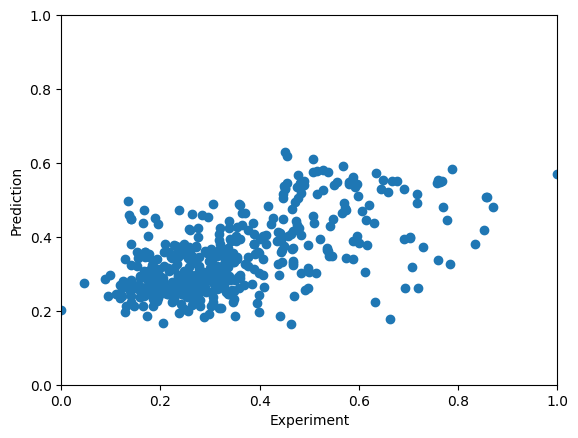

In [31]:
plt.scatter(y_true, preds)
plt.xlabel("Experiment")
plt.ylabel("Prediction")
plt.xlim(0,1)
plt.ylim(0,1);

This model generally underestimates the wavelength as compared to the experimental values.

# Calculation of correlation coefficient

In [32]:
import numpy as np
np.corrcoef(preds, y_true)

array([[1.        , 0.60284195],
       [0.60284195, 1.        ]])

# Use Extended-Connectivity Fingerprint (ECFP)

![picture](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_generation.png)

![picture](https://docs.chemaxon.com/display/docs/images/download/attachments/1806333/ecfp_folding.png)

radius = 2, nBits = 1024 will be used for this practice.

In [33]:
from rdkit.Chem import AllChem

X_ECFP = []
for smi in tqdm(smiles):
  vec = AllChem.GetMorganFingerprintAsBitVect(rdkit.Chem.MolFromSmiles(smi), 2, nBits = 1024)
  X_ECFP.append([int(x) for x in vec.ToBitString()])

100%|██████████| 2429/2429 [00:03<00:00, 705.57it/s]


In [34]:
# transform X_ECFP to tensor
X_ECFP = torch.Tensor(X_ECFP)
print(X_ECFP.shape)

torch.Size([2429, 1024])


In [35]:
# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X_ECFP, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [36]:
# Dataset
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader
loader_train = DataLoader(ds_train, batch_size=128, shuffle=True, drop_last=True)
loader_test = DataLoader(ds_test, batch_size=128, shuffle=False)

In [37]:
# model
if model is not None:
  del model

model = nn.Sequential(
    nn.Linear(1024, 64),      # input_dim = 1024
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(64),
    nn.Linear(64, 64),
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32),
    nn.LeakyReLU(0.1),
    nn.BatchNorm1d(32),
    nn.Linear(32, 1)           # final output_dim = 1
)

print(model)

Sequential(
  (0): Linear(in_features=1024, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.1)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): LeakyReLU(negative_slope=0.1)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.1)
  (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=32, out_features=1, bias=True)
)


In [38]:
# see how many parameters this model has
from prettytable import PrettyTable

def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    total_params += param
  print(table)
  print(f"Total Trainable Params: {total_params}")

  return total_params

count_parameters(model)

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |   65536    |
|  0.bias  |     64     |
| 2.weight |     64     |
|  2.bias  |     64     |
| 3.weight |    4096    |
|  3.bias  |     64     |
| 5.weight |     64     |
|  5.bias  |     64     |
| 6.weight |    2048    |
|  6.bias  |     32     |
| 8.weight |     32     |
|  8.bias  |     32     |
| 9.weight |     32     |
|  9.bias  |     1      |
+----------+------------+
Total Trainable Params: 72193


72193

In [39]:
# loss function
loss_fn = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

epoch 0 // Loss: 0.34907 // Val_loss: 0.25286
epoch 1 // Loss: 0.19424 // Val_loss: 0.19336
epoch 2 // Loss: 0.12596 // Val_loss: 0.16820
epoch 3 // Loss: 0.13199 // Val_loss: 0.15422
epoch 4 // Loss: 0.13081 // Val_loss: 0.14507
epoch 5 // Loss: 0.13053 // Val_loss: 0.13602
epoch 6 // Loss: 0.11224 // Val_loss: 0.13103
epoch 7 // Loss: 0.11217 // Val_loss: 0.12542
epoch 8 // Loss: 0.08853 // Val_loss: 0.11949
epoch 9 // Loss: 0.08923 // Val_loss: 0.11578
epoch 10 // Loss: 0.08700 // Val_loss: 0.11307
epoch 11 // Loss: 0.10554 // Val_loss: 0.10945
epoch 12 // Loss: 0.07718 // Val_loss: 0.10612
epoch 13 // Loss: 0.07545 // Val_loss: 0.10342
epoch 14 // Loss: 0.07486 // Val_loss: 0.10152
epoch 15 // Loss: 0.07485 // Val_loss: 0.09936
epoch 16 // Loss: 0.06317 // Val_loss: 0.09754
epoch 17 // Loss: 0.08982 // Val_loss: 0.09560
epoch 18 // Loss: 0.06651 // Val_loss: 0.09229
epoch 19 // Loss: 0.06673 // Val_loss: 0.08941
epoch 20 // Loss: 0.06087 // Val_loss: 0.08727
epoch 21 // Loss: 0.067

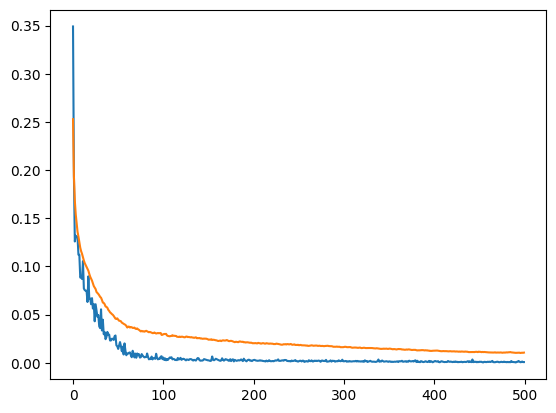

In [40]:
# model training
n_epoch = 500
loss_list = []
val_loss_list = []
for epoch in range(n_epoch):

  train_loss, val_loss = train(epoch, X_val, y_val)

  loss_list.append(train_loss)
  val_loss_list.append(val_loss)

plt.plot(loss_list)
plt.plot(val_loss_list)

test()

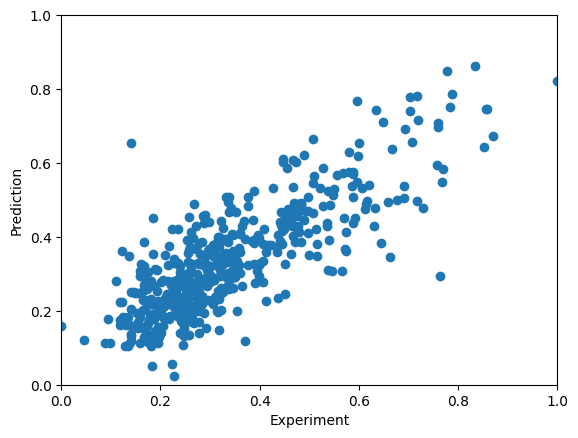

In [43]:
# scatter plot
outputs = model(X_test)
outputs = outputs[:,0]

preds = outputs.detach().numpy()
y_true = y_test.detach().numpy()

plt.scatter(y_true, preds)
plt.xlabel("Experiment")
plt.ylabel("Prediction")
plt.xlim(0, 1.0)
plt.ylim(0, 1.0);

In [44]:
np.corrcoef(y_true, preds)

array([[1.        , 0.81530807],
       [0.81530807, 1.        ]])